In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!nvidia-smi

Thu Apr 25 21:33:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
''' nvcc4jupyter is a Jupyter Notebook plugin that provides cell and line magics to allow running CUDA C++ code from a notebook.
This is especially useful when combined with a hosted service such a Google's Colab which provide CUDA capable GPUs and you can start learning
CUDA C++ without having to install anything or even to own a GPU yourself.'''

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-orw1zmjb
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-orw1zmjb
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5741c522547756ac4bb7a16df32106a15efb8a57
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10741 sha256=1c43b610d84440f376c57bb0b3d20f87e2433fdb6f06eb98d5fd7c81c461a971
  Stored in directory: /tmp/pip-ephem-wheel-cache-7836u9k4/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter


" nvcc4jupyter is a Jupyter Notebook plugin that provides cell and line magics to allow running CUDA C++ code from a notebook.\nThis is especially useful when combined with a hosted service such a Google's Colab which provide CUDA capable GPUs and you can start learning \nCUDA C++ without having to install anything or even to own a GPU yourself."

In [7]:
%load_ext nvcc_plugin

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpvlzq38o3".


# c++ hello world!

In [9]:
%%cuda
#include <iostream>
int main() {
    std::cout << "Hello world\n";
    return 0;
}

Hello world



# cuda hello world

- `__global__`: is a indicates that the function runs on device(GPU) and is called from Host (CPU). It defines kernal code.
- `hello_world<<<1,1>>()`: The `<<<M,T>>>` signifies the kernal launch. It needs to be called for code that has `__global__` in it. The kernel launches with a grid of `M` thread blocks. Each thread block has `T` parallel threads.
- `cudaDeviceSynchronize()`: The cuda code launches asynchronously and host might not always wait for device to complete its execution. The cudaDeviceSyncronize waits for device to complete execution.

NVIDIA compiler separates the device code and host code. Device code: hello_world is compiled with NVDIA compiler and the main function is compiled using gcc.

In [11]:
%%cuda
#include <stdio.h>
#include <cuda.h>

__global__ void hello_world() {
    printf("Hello, World\n");
}

int main() {
    hello_world<<<1,1>>>();
    cudaDeviceSynchronize();
    return 0;
}

Hello, World
Hello, World



# How indexing works?

Hierarchy of threads:

1. `Threads`: A single process running in one of the cuda cores. Each kernel call creates a single grid.
2. `Blocks`: Blocks are collections of threads.
3. `grid`: Grids are Collections of blocks.

Inbuilt variables

1. `threadIdx.x`: We can get index of the current thread within its block with using inbuilt variable.
2. `blockIdx.x`: We can get index of the current block in the grid.
3. `blockDim.x`: Number of threads in the block can be gotten with using inbuilt variable.
4. `gridDim.x`: number of blocks in a grid

consider: $2^{20}$ elements with
BLOCKS_NUM = $2^{13} = 4096$ ,
BLOCK_SIZE = $2^{7} = 256$

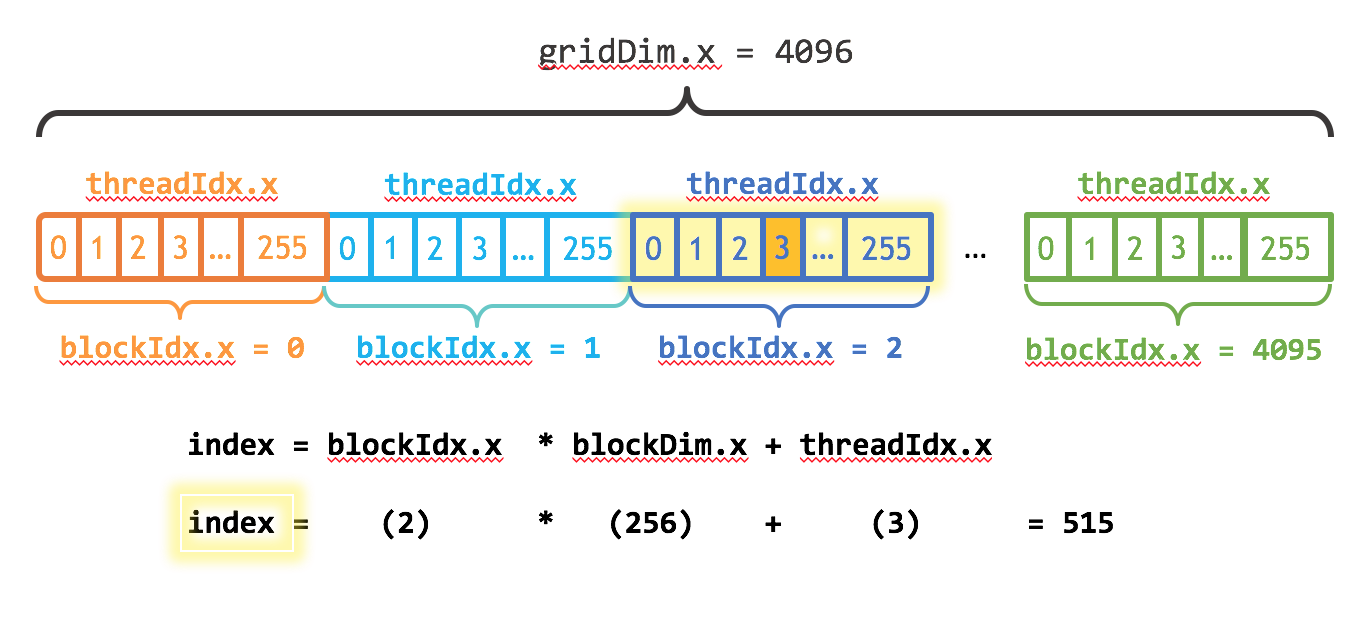

### CPU only

In [12]:
%%writefile vector_add_cpu.cu
// %%cuda

#include <iostream>
#include <math.h>
#include <chrono>
#define N  100000000

using namespace std;
using namespace std::chrono;

// __global__ indicates that function runs on GPU.
void vector_add(float *x, float *y, float *sum, int n) {
    for (int i = 0; i < n; i++) { //TODO how many iterations are done by this loop?
        sum[i] = x[i] + y[i];
    }
}


int main() {
    // declaring memory in host
    float *h_x, *h_y, *h_sum;

    // allocating memory on host
    h_x = (float *) malloc(sizeof(float) * N);
    h_y = (float *) malloc(sizeof(float) * N);
    h_sum = (float *) malloc(sizeof(float) * N);

    // initializing h_x and h_y
    for (int i = 0; i < N; i++) {
        h_x[i] = 1.0f;
        h_y[i] = 2.0f;
    }

     // Get starting timepoint
    auto start = high_resolution_clock::now();

    // do vector add on cpu
    vector_add(h_x, h_y, h_sum, N);

    // Get ending timepoint
    auto stop = high_resolution_clock::now();

    // Get duration. Substart timepoints to
    // get duration. To cast it to proper unit
    // use duration cast method
    auto duration = duration_cast<microseconds>(stop - start);

    cout << "Time taken by function: " << duration.count()/1000 << " millisecond" << endl;

    // Check for errors (all values should be 3.0f)
    float maxError = 0.0f;
    for (int i = 0; i < N; i++)
        maxError = fmax(maxError, fabs(h_sum[i] - 3.0f));

    cout << "Max error: " << maxError << endl;


    // deallocating memory from host
    free(h_x);
    free(h_y);
    free(h_sum);

    return 0;
}

Writing vector_add_cpu.cu


In [13]:
!nvcc vector_add_cpu.cu -o vector_add_cpu.o

In [14]:
!./vector_add_cpu.o

Time taken by function: 489 millisecond
Max error: 0


### Single Thread

In [15]:
%%writefile vector_add_single.cu
// %%cu

#include <iostream>
#include <cuda.h>
#include <assert.h>     /* assert */

#define BLOCK_SIZE  256
#define N  100000000

using namespace std;

__global__
void vector_add_single_thread(float *x, float *y, float *sum, int n) {
    for (int i = 0; i < n; i += 1)
        sum[i] = x[i] + y[i]; //TODO how many iterations are done by this loop?

}


int main() {
    // declaring memory in host
    float *h_x, *h_y, *h_sum;

    // declaring memory in device
    float *d_x, *d_y, *d_sum;

    // allocating memory on host
    h_x = (float *) malloc(sizeof(float) * N);
    h_y = (float *) malloc(sizeof(float) * N);
    h_sum = (float *) malloc(sizeof(float) * N);

    // initializing h_x and h_y
    for (int i = 0; i < N; i++) {
        h_x[i] = 1.0f;
        h_y[i] = 2.0f;
    }

    // allocating memory on device
    cudaMalloc((void **) &d_x, sizeof(float) * N);
    cudaMalloc((void **) &d_y, sizeof(float) * N);
    cudaMalloc((void **) &d_sum, sizeof(float) * N);

    // transfer from device to host
    cudaMemcpy(d_x, h_x, sizeof(float) * N, cudaMemcpyHostToDevice); // dist, src
    cudaMemcpy(d_y, h_y, sizeof(float) * N, cudaMemcpyHostToDevice); // dist, src

    vector_add_single_thread<<<1, 1 >> > (d_x, d_y, d_sum, N);  // mode 1


    // transfer back from host to device
    cudaMemcpy(h_sum, d_sum, sizeof(float) * N, cudaMemcpyDeviceToHost); // dist, src


    // Wait for GPU to finish before accessing on host
    cudaDeviceSynchronize();


    // Check for errors (all values should be 3.0f)
    float maxError = 0.0f;
    for (int i = 0; i < N; i++)
        maxError = fmax(maxError, fabs(h_sum[i] - 3.0f));

    cout << "Max error: " << maxError << endl;

    // deallocating memory from device
    cudaFree(d_x);
    cudaFree(d_y);
    cudaFree(d_sum);

    // deallocating memory from host
    free(h_x);
    free(h_y);
    free(h_sum);

    return 0;
}

Writing vector_add_single.cu


In [16]:
!nvcc vector_add_single.cu -o vector_add.o

In [17]:
!./vector_add.o

Max error: 0


In [18]:
# single thread
!nvprof ./vector_add.o

==3759== NVPROF is profiling process 3759, command: ./vector_add.o
Max error: 0
==3759== Profiling application: ./vector_add.o
==3759== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   92.08%  5.43869s         1  5.43869s  5.43869s  5.43869s  vector_add_single_thread(float*, float*, float*, int)
                    5.04%  297.49ms         1  297.49ms  297.49ms  297.49ms  [CUDA memcpy DtoH]
                    2.88%  170.38ms         2  85.190ms  84.104ms  86.276ms  [CUDA memcpy HtoD]
      API calls:   96.87%  5.90819s         3  1.96940s  84.323ms  5.73736s  cudaMemcpy
                    3.06%  186.48ms         3  62.160ms  410.18us  185.65ms  cudaMalloc
                    0.07%  3.9977ms         3  1.3326ms  482.06us  2.1694ms  cudaFree
                    0.01%  305.02us         1  305.02us  305.02us  305.02us  cudaLaunchKernel
                    0.00%  139.26us       114  1.2210us     140ns  57.601us  cuDevice

### Single Block

In [19]:
%%writefile vector_add_block.cu
// %%cu

#include <iostream>
#include <cuda.h>
#include <assert.h>     /* assert */

#define BLOCK_SIZE  256
#define N  100000000

using namespace std;

__global__
void vector_add_single_block(float *x, float *y, float *sum, int n) {
  int index = threadIdx.x;
  int stride = blockDim.x;
  for (int i = index; i < n; i += stride) //TODO how many iterations are done by this loop?
      sum[i] = x[i] + y[i];
  // assert(gridDim.x==1); // assert gridDim.x==1 which means number of blocks is 1
}

int main() {
    // declaring memory in host
    float *h_x, *h_y, *h_sum;

    // declaring memory in device
    float *d_x, *d_y, *d_sum;

    // allocating memory on host
    h_x = (float *) malloc(sizeof(float) * N);
    h_y = (float *) malloc(sizeof(float) * N);
    h_sum = (float *) malloc(sizeof(float) * N);

    // initializing h_x and h_y
    for (int i = 0; i < N; i++) {
        h_x[i] = 1.0f;
        h_y[i] = 2.0f;
    }

    // allocating memory on device
    cudaMalloc((void **) &d_x, sizeof(float) * N);
    cudaMalloc((void **) &d_y, sizeof(float) * N);
    cudaMalloc((void **) &d_sum, sizeof(float) * N);

    // transfer from device to host
    cudaMemcpy(d_x, h_x, sizeof(float) * N, cudaMemcpyHostToDevice); // dist, src
    cudaMemcpy(d_y, h_y, sizeof(float) * N, cudaMemcpyHostToDevice); // dist, src

    // run the kernel
    vector_add_single_block<<<1, BLOCK_SIZE >> > (d_x, d_y, d_sum, N); // mode 2

    // transfer back from host to device
    cudaMemcpy(h_sum, d_sum, sizeof(float) * N, cudaMemcpyDeviceToHost); // dist, src


    // Wait for GPU to finish before accessing on host
    cudaDeviceSynchronize();


    // Check for errors (all values should be 3.0f)
    float maxError = 0.0f;
    for (int i = 0; i < N; i++)
        maxError = fmax(maxError, fabs(h_sum[i] - 3.0f));

    cout << "Max error: " << maxError << endl;

    // deallocating memory from device
    cudaFree(d_x);
    cudaFree(d_y);
    cudaFree(d_sum);

    // deallocating memory from host
    free(h_x);
    free(h_y);
    free(h_sum);

    return 0;
}

Writing vector_add_block.cu


In [20]:
!nvcc vector_add_block.cu -o vector_add.o

In [21]:
!./vector_add.o

Max error: 0


In [22]:
# single block
!nvprof ./vector_add.o

==3908== NVPROF is profiling process 3908, command: ./vector_add.o
Max error: 0
==3908== Profiling application: ./vector_add.o
==3908== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   43.33%  284.07ms         1  284.07ms  284.07ms  284.07ms  [CUDA memcpy DtoH]
                   30.61%  200.67ms         1  200.67ms  200.67ms  200.67ms  vector_add_single_block(float*, float*, float*, int)
                   26.06%  170.84ms         2  85.422ms  83.887ms  86.958ms  [CUDA memcpy HtoD]
      API calls:   78.32%  657.15ms         3  219.05ms  84.155ms  485.80ms  cudaMemcpy
                   21.15%  177.46ms         3  59.153ms  455.75us  176.53ms  cudaMalloc
                    0.47%  3.9841ms         3  1.3280ms  531.70us  2.0952ms  cudaFree
                    0.03%  271.85us         1  271.85us  271.85us  271.85us  cudaLaunchKernel
                    0.02%  139.54us       114  1.2230us     143ns  54.785us  cuDeviceG

### Multi-block

In [23]:
%%writefile vector_add.cu
// %%cu

#include <iostream>
#include <cuda.h>
#include <assert.h>     /* assert */

#define BLOCK_SIZE  256
#define N  100000000

using namespace std;

// __global__ indicates that function runs on GPU.
__global__
void vector_add(float *x, float *y, float *sum, int n) {
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;
    /*if (index > n){
        printf("exceeding ");
    }*/
    for (int i = index; i < n; i += stride) { //TODO how many iterations are done by this loop?  assert (stride == n);
        sum[i] = x[i] + y[i];
    }
}

int main() {
    // declaring memory in host
    float *h_x, *h_y, *h_sum;

    // declaring memory in device
    float *d_x, *d_y, *d_sum;

    // allocating memory on host
    h_x = (float *) malloc(sizeof(float) * N);
    h_y = (float *) malloc(sizeof(float) * N);
    h_sum = (float *) malloc(sizeof(float) * N);

    // initializing h_x and h_y
    for (int i = 0; i < N; i++) {
        h_x[i] = 1.0f;
        h_y[i] = 2.0f;
    }

    // allocating memory on device
    cudaMalloc((void **) &d_x, sizeof(float) * N);
    cudaMalloc((void **) &d_y, sizeof(float) * N);
    cudaMalloc((void **) &d_sum, sizeof(float) * N);

    // transfer from device to host
    cudaMemcpy(d_x, h_x, sizeof(float) * N, cudaMemcpyHostToDevice); // dist, src
    cudaMemcpy(d_y, h_y, sizeof(float) * N, cudaMemcpyHostToDevice); // dist, src

    // run the kernel
    int BLOCKS_NUM = (N + BLOCK_SIZE - 1) / BLOCK_SIZE;
    cout << "parallel units: " << BLOCK_SIZE*BLOCKS_NUM << endl;
    vector_add<<<BLOCKS_NUM, BLOCK_SIZE >> > (d_x, d_y, d_sum, N); // mode 3


    // transfer back from host to device
    cudaMemcpy(h_sum, d_sum, sizeof(float) * N, cudaMemcpyDeviceToHost); // dist, src


    // Wait for GPU to finish before accessing on host
    cudaDeviceSynchronize();


    // Check for errors (all values should be 3.0f)
    float maxError = 0.0f;
    for (int i = 0; i < N; i++)
        maxError = fmax(maxError, fabs(h_sum[i] - 3.0f));

    cout << "Max error: " << maxError << endl;

    // deallocating memory from device
    cudaFree(d_x);
    cudaFree(d_y);
    cudaFree(d_sum);

    // deallocating memory from host
    free(h_x);
    free(h_y);
    free(h_sum);

    return 0;
}

Writing vector_add.cu


In [24]:
!nvcc vector_add.cu -o vector_add.o

In [25]:
# multi-block
!nvprof ./vector_add.o

==3968== NVPROF is profiling process 3968, command: ./vector_add.o
parallel units: 100000000
Max error: 0
==3968== Profiling application: ./vector_add.o
==3968== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   62.41%  289.84ms         1  289.84ms  289.84ms  289.84ms  [CUDA memcpy DtoH]
                   36.49%  169.49ms         2  84.745ms  84.293ms  85.198ms  [CUDA memcpy HtoD]
                    1.10%  5.1195ms         1  5.1195ms  5.1195ms  5.1195ms  vector_add(float*, float*, float*, int)
      API calls:   66.87%  466.10ms         3  155.37ms  84.513ms  296.17ms  cudaMemcpy
                   26.71%  186.18ms         3  62.060ms  415.28us  185.32ms  cudaMalloc
                    5.83%  40.642ms         1  40.642ms  40.642ms  40.642ms  cudaLaunchKernel
                    0.56%  3.9365ms         3  1.3122ms  487.94us  2.0839ms  cudaFree
                    0.02%  141.47us       114  1.2400us     148ns  56.634